Step 1: Setup Google Colab Environment

In [3]:
!pip install --upgrade pip setuptools wheel
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 164.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 177.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 182.

In [2]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

Step 2: Check GPU Availability

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Step 3: Download and Load Caltech-101 Dataset

In [5]:
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (standard for pre-trained models)
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])

# Load the Caltech101 dataset
dataset = datasets.Caltech101(root="./data", download=True, transform=transform)


Files already downloaded and verified


Step 4: Split Dataset into Training, Validation, and Test

In [6]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [7]:
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [8]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

Step 5: Load Pretrained ResNet50 Model

In [9]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 101)  # Adjust final layer for 101 classes
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 6: Define Loss Function and Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Step 7: Train the Model

In [11]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel RGB
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])


In [12]:
dataset = datasets.Caltech101(root="./data", download=True, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


Files already downloaded and verified


In [13]:
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 3.0441
Epoch 2/10, Loss: 1.9828
Epoch 3/10, Loss: 1.3773
Epoch 4/10, Loss: 0.9907
Epoch 5/10, Loss: 0.6908
Epoch 6/10, Loss: 0.5367
Epoch 7/10, Loss: 0.3734
Epoch 8/10, Loss: 0.2754
Epoch 9/10, Loss: 0.1773
Epoch 10/10, Loss: 0.1823


Step 8: Validate the Model

In [15]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel RGB
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])


In [17]:
dataset = datasets.Caltech101(root="./data", download=True, transform=transform)

# Split into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Files already downloaded and verified


In [18]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 93.49%


Step 9: Evaluate on Test Data

In [20]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel RGB
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])


In [22]:
test_dataset = datasets.Caltech101(root="./data", download=True, transform=transform)

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Files already downloaded and verified


In [23]:
y_pred, y_true = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("Classification Report:")
print(classification_report(y_true, y_pred))


Confusion Matrix:
[[434   1   0 ...   0   0   0]
 [  6 427   0 ...   0   0   0]
 [  0   0 197 ...   0   0   0]
 ...
 [  0   0   0 ...  55   0   0]
 [  0   0   0 ...   0  35   1]
 [  0   0   0 ...   0   0  58]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       435
           1       1.00      0.98      0.99       435
           2       1.00      0.98      0.99       200
           3       1.00      0.97      0.99       798
           4       0.96      1.00      0.98        55
           5       0.98      1.00      0.99       800
           6       0.85      0.95      0.90        42
           7       0.87      0.93      0.90        42
           8       1.00      0.91      0.96        47
           9       1.00      0.69      0.81        54
          10       0.57      0.89      0.69        46
          11       0.95      0.61      0.74        33
          12       0.98      0.98      0.98       128
          

Step 10: Apply Grad-CAM for Explainability

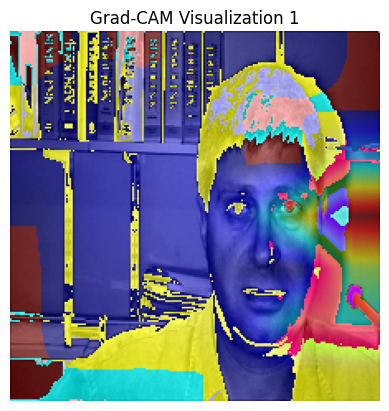

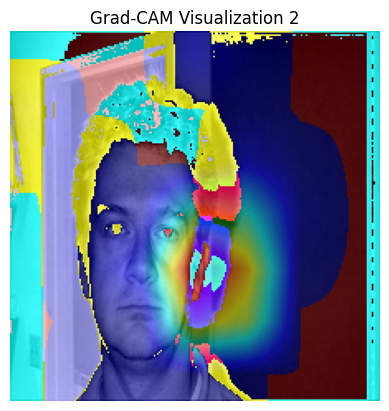

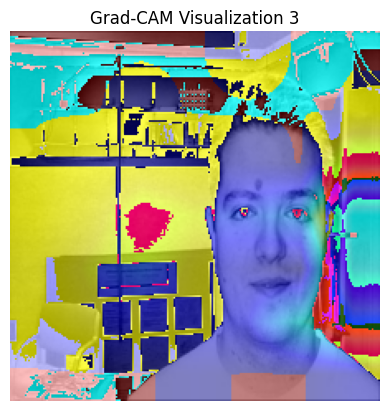

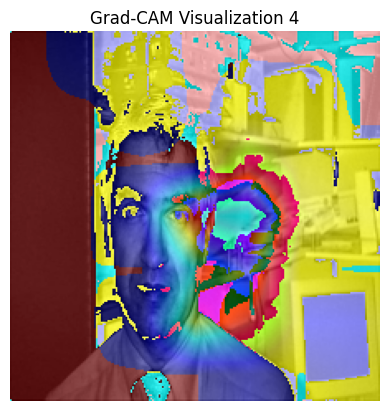

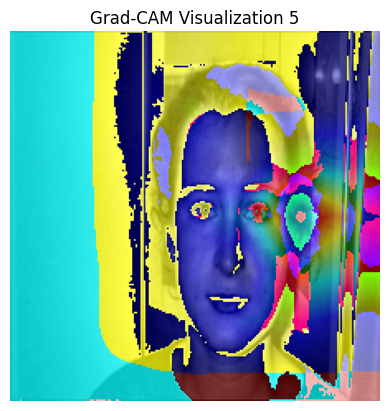

Grad-CAM visualizations for 5 test images displayed.


In [29]:
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

# Adjust based on the model architecture (e.g., ResNet)
target_layer = model.layer4[-1]  # Choose the appropriate layer

# Initialize Grad-CAM with the target layer as a list
cam = GradCAM(model=model, target_layers=[target_layer])

# Iterate over the first 5 images in the test dataset
for i, (images, labels) in enumerate(test_loader):
    if i >= 5:  # Stop after 5 images
        break

    # Get one test image
    image = images[0].unsqueeze(0).to(device)

    # Generate Grad-CAM visualization
    grayscale_cam = cam(input_tensor=image)

    # Normalize and convert the mask to uint8
    grayscale_cam = np.uint8(255 * grayscale_cam[0])  # Scale the values between 0 and 255
    grayscale_cam = np.squeeze(grayscale_cam)  # Remove the extra dimension

    # Convert the image from tensor to numpy and prepare for visualization
    image_np = image.cpu().squeeze().permute(1, 2, 0).numpy()
    cam_image = show_cam_on_image(image_np, grayscale_cam)

    # Display the image with Grad-CAM overlay
    plt.imshow(cam_image)
    plt.title(f"Grad-CAM Visualization {i+1}")
    plt.axis("off")
    plt.show()

print("Grad-CAM visualizations for 5 test images displayed.")


Step 11: Save and Export the Model

In [32]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [33]:
model_save_path = '/content/drive/MyDrive/AI lab 7/caltech101_resnet50.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved successfully at {model_save_path}")


Model saved successfully at /content/drive/MyDrive/AI lab 7/caltech101_resnet50.pth
